In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
import timeit

In [2]:
record_list = [] # Initialize the array that will hold the list of our records

records = 'mit-bih-dataframes/subject_list.csv' # Get our record list like we did in the initial extraction
with open(records) as rfile:# Load our records into the array
    for record in rfile:
        record = record[0:-1] # The -1 removes the newline ("\n") character from the string
        record_list.append(record)

In [3]:
dfdic = {}
for idx, x in enumerate(record_list):
    dfdic[x] = pd.read_csv('mit-bih-features/'+x+ '.csv', index_col=0)

In [4]:
subject_df = pd.DataFrame()
for idx, x in enumerate(record_list):
    subject_df = pd.concat([subject_df, dfdic[x]])

In [5]:
subject_df['Mappedrhythmlabels'] = subject_df['rhythmLabel'].map({'Normal':0, 'Other':0, 'AFIB':1})

In [6]:
subject_df.head()

,subsetID,rhythmLabel,StoS,StoR,StoL,RtoS,RtoR,RtoL,LtoS,LtoR,LtoL,RMS,STD,CoefVar,Range,IQR,MAD,Mappedrhythmlabels
0,04015-0.csv,Normal,0.200000,0.057143,0.028571,0.057143,0.228571,0.142857,0.057143,0.114286,0.114286,156.276998,43.660906,0.248152,155.0,78.00,32.5,0
1,04015-1.csv,Normal,0.000000,0.052632,0.000000,0.052632,0.184211,0.236842,0.000000,0.210526,0.263158,197.783973,57.233572,0.355262,213.0,93.50,55.0,0
2,04015-2.csv,Normal,0.333333,0.083333,0.055556,0.027778,0.305556,0.083333,0.111111,0.000000,0.000000,151.638551,43.820505,0.253179,138.0,72.00,56.0,0
3,04015-3.csv,Normal,0.300000,0.175000,0.000000,0.125000,0.025000,0.125000,0.075000,0.050000,0.125000,157.611865,48.827831,0.318730,167.0,79.00,59.0,0
4,04015-4.csv,Normal,0.090909,0.151515,0.090909,0.030303,0.060606,0.212121,0.212121,0.060606,0.090909,226.855681,53.260256,0.289227,237.0,95.75,66.5,0


In [7]:
stattransitions_dic = {
    'Accuracy': [],
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1_Score': []
}

In [8]:
indaccs_dic = {}

In [9]:
#Logistic Regression

kf = KFold(n_splits=5, random_state=3, shuffle=True)
model = LogisticRegression(solver='liblinear')

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df): 
    #X_train = subject_df.loc[train_index, ["StoS", "StoR", "StoL", "RtoS", "RtoR", "RtoL","LtoS", "LtoR", "LtoL"]]
    #X_test = subject_df.loc[test_index, ["StoS", "StoR", "StoL", "RtoS", "RtoR", "RtoL","LtoS", "LtoR", "LtoL"]]
    #Y_train = subject_df.loc[train_index, "rhythmLabel"]
    #Y_test = subject_df.loc[test_index, "rhythmLabel"]
    
    X_train = subject_df.iloc[train_index, 2:11]
    X_test = subject_df.iloc[test_index, 2:11]
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)


stattransitions_dic['Accuracy'].append(np.mean(acc_score))
stattransitions_dic['Standard Error'].append(np.std(acc_score))
stattransitions_dic['Sensitivity'].append(sensitivity)
stattransitions_dic['Specificity'].append(specificity)
stattransitions_dic['Precision'].append(precision)
stattransitions_dic['F1_Score'].append(f1_score)

indaccs_dic['LogReg'] = acc_score

---Run time is 0.3109395629999998 seconds ---

Accuracy of each fold: 
 [0.9246649206593746, 0.9283513097072419, 0.9312788906009245, 0.9306625577812019, 0.9343605546995377]
Avg accuracy: 0.929863646689656
Std of accuracy : 
0.003230395375065387

[[18564   862]
 [ 1414 11611]]

              precision    recall  f1-score   support

           0       0.93      0.96      0.94     19426
           1       0.93      0.89      0.91     13025

    accuracy                           0.93     32451
   macro avg       0.93      0.92      0.93     32451
weighted avg       0.93      0.93      0.93     32451

0.9556264799752908
0.8914395393474088
0.9292221443587947
0.9422393665617703


In [10]:
#LDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=LinearDiscriminantAnalysis()

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    X_train = subject_df.iloc[train_index, 2:11]
    X_test = subject_df.iloc[test_index, 2:11]
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)
    

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)


stattransitions_dic['Accuracy'].append(np.mean(acc_score))
stattransitions_dic['Standard Error'].append(np.std(acc_score))
stattransitions_dic['Sensitivity'].append(sensitivity)
stattransitions_dic['Specificity'].append(specificity)
stattransitions_dic['Precision'].append(precision)
stattransitions_dic['F1_Score'].append(f1_score)

indaccs_dic['LDA'] = acc_score

---Run time is 0.2927010059999997 seconds ---

Accuracy of each fold: 
 [0.9177322446464335, 0.923728813559322, 0.9265023112480739, 0.9265023112480739, 0.9275808936825886]
Avg accuracy: 0.9244093148768983
Std of accuracy : 
0.0035739761791593943

[[18710   716]
 [ 1737 11288]]

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     19426
           1       0.94      0.87      0.90     13025

    accuracy                           0.92     32451
   macro avg       0.93      0.91      0.92     32451
weighted avg       0.93      0.92      0.92     32451

0.9631421805827242
0.866641074856046
0.9150486623954615
0.9384796729616534


In [11]:
#QDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=QuadraticDiscriminantAnalysis()

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    X_train = subject_df.iloc[train_index, 2:11]
    X_test = subject_df.iloc[test_index, 2:11]
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)
    

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)


stattransitions_dic['Accuracy'].append(np.mean(acc_score))
stattransitions_dic['Standard Error'].append(np.std(acc_score))
stattransitions_dic['Sensitivity'].append(sensitivity)
stattransitions_dic['Specificity'].append(specificity)
stattransitions_dic['Precision'].append(precision)
stattransitions_dic['F1_Score'].append(f1_score)

indaccs_dic['QDA'] = acc_score

/Users/JJ/Python/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/JJ/Python/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/JJ/Python/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/JJ/Python/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/JJ/Python/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


---Run time is 0.1254671949999997 seconds ---

Accuracy of each fold: 
 [0.9074102603604991, 0.910477657935285, 0.9112480739599383, 0.9121725731895224, 0.9149460708782743]
Avg accuracy: 0.9112509272647038
Std of accuracy : 
0.0024434481128874684

[[17635  1791]
 [ 1089 11936]]

              precision    recall  f1-score   support

           0       0.94      0.91      0.92     19426
           1       0.87      0.92      0.89     13025

    accuracy                           0.91     32451
   macro avg       0.91      0.91      0.91     32451
weighted avg       0.91      0.91      0.91     32451

0.9078039740553897
0.9163915547024952
0.9418393505661183
0.9245085190039318


In [12]:
#KNN-CV
KNN_result = []
X=subject_df[["StoS", "StoR", "StoL", "RtoS", "RtoR", "RtoL","LtoS", "LtoR", "LtoL"]]
Y=subject_df["Mappedrhythmlabels"]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,26):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K = {}'.format(k))
    print('Accuracy of each fold: \n {}'.format(scores))
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(np.max(KNN_result))

K = 1
Accuracy of each fold: 
 [0.93144354 0.93420647 0.93297381 0.93420647 0.93405239]
Avg accuracy: 0.9333765348678827

K = 2
Accuracy of each fold: 
 [0.92235403 0.92557781 0.92619414 0.93004622 0.92804314]
Avg accuracy: 0.9264430707541246

K = 3
Accuracy of each fold: 
 [0.94284394 0.94637904 0.9440678  0.94653313 0.94791988]
Avg accuracy: 0.945548756735354

K = 4
Accuracy of each fold: 
 [0.94053305 0.9431433  0.94237288 0.94668721 0.94360555]
Avg accuracy: 0.9432683965163097

K = 5
Accuracy of each fold: 
 [0.94453859 0.94730354 0.94637904 0.94699538 0.94992296]
Avg accuracy: 0.9470279032791403

K = 6
Accuracy of each fold: 
 [0.94315206 0.94745763 0.94761171 0.94853621 0.94915254]
Avg accuracy: 0.9471820292124284

K = 7
Accuracy of each fold: 
 [0.94469265 0.94853621 0.94822804 0.94884438 0.95007704]
Avg accuracy: 0.9480756643250736

K = 8
Accuracy of each fold: 
 [0.94361424 0.94838213 0.94745763 0.94853621 0.94961479]
Avg accuracy: 0.9475209980204902

K = 9
Accuracy of each fo

In [13]:
#KNN-CV
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=neighbors.KNeighborsClassifier(n_neighbors=7)

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df): 
    X_train = subject_df.iloc[train_index, 2:11]
    X_test = subject_df.iloc[test_index, 2:11]
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print()


print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)


stattransitions_dic['Accuracy'].append(np.mean(acc_score))
stattransitions_dic['Standard Error'].append(np.std(acc_score))
stattransitions_dic['Sensitivity'].append(sensitivity)
stattransitions_dic['Specificity'].append(specificity)
stattransitions_dic['Precision'].append(precision)
stattransitions_dic['F1_Score'].append(f1_score)

indaccs_dic['KNN-CV'] = acc_score


---Run time is 6.319878189999997 seconds ---

Accuracy of each fold: 
 [0.9446926513634263, 0.9485362095531588, 0.9482280431432973, 0.9488443759630201, 0.9500770416024653]
Avg accuracy: 0.9480756643250736
Std of accuracy : 
0.0018042464631420633

[[18405  1021]
 [  664 12361]]

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     19426
           1       0.92      0.95      0.94     13025

    accuracy                           0.95     32451
   macro avg       0.94      0.95      0.95     32451
weighted avg       0.95      0.95      0.95     32451

0.9474415731493874
0.949021113243762
0.9651790864754314
0.9562280815690349


In [14]:
print(stattransitions_dic['Accuracy'])

[0.929863646689656, 0.9244093148768983, 0.9112509272647038, 0.9480756643250736]


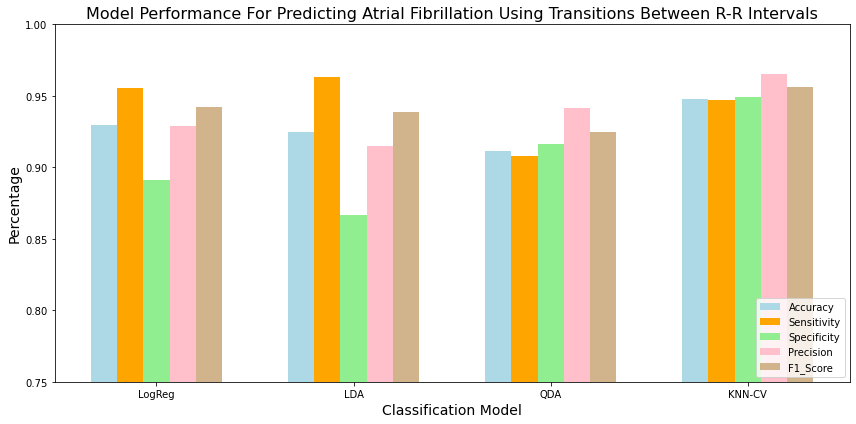

In [34]:
models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']
accuracies = stattransitions_dic["Accuracy"]
sensitivities = stattransitions_dic["Sensitivity"]
specificities = stattransitions_dic["Specificity"]
precisions = stattransitions_dic["Precision"]
f1_scores = stattransitions_dic["F1_Score"]



x = 6*np.arange(len(models))
width = 0.8

fig, ax = plt.subplots(figsize=(12, 6))
acc = ax.bar(x-width*2, accuracies, width, label='Accuracy', color='lightblue')
sen = ax.bar(x-width, sensitivities, width, label='Sensitivity', color='orange')
spe = ax.bar(x,specificities, width, label='Specificity', color='lightgreen')
pre = ax.bar(x+width, precisions, width, label='Precision', color='pink')
f1 = ax.bar(x+width*2 , f1_scores, width, label='F1_Score', color='tan')

ax.set_xlabel('Classification Model', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
ax.set(ylim=(0.75, 1.0))
ax.set_title('Model Performance For Predicting Atrial Fibrillation Using Transitions Between R-R Intervals', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()


fig.tight_layout()

plt.legend(loc="lower right", prop={'size': 10})
plt.show()

fig.savefig('TransitionsModel.png')

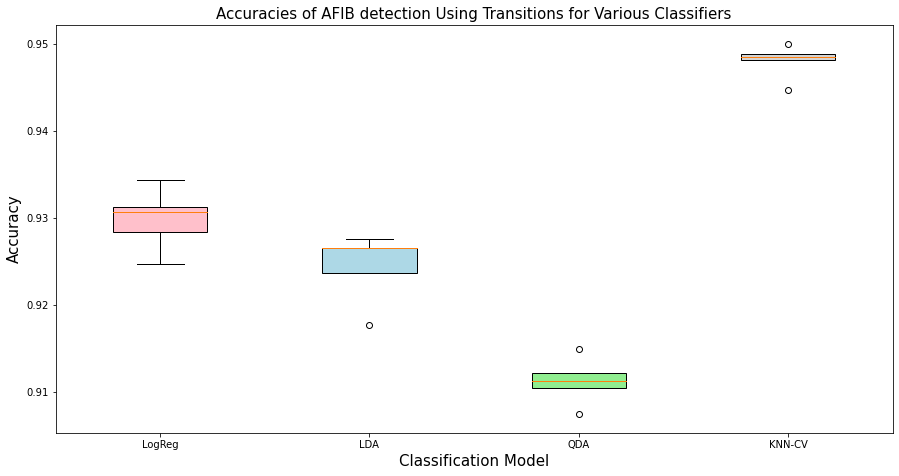

In [25]:
models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']

x = np.arange(len(models))+1

LogRegAcc = indaccs_dic['LogReg']
LDAAcc = indaccs_dic['LDA']
QDAAcc = indaccs_dic['QDA']
KNNAcc = indaccs_dic['KNN-CV']

data = [LogRegAcc, LDAAcc, QDAAcc, KNNAcc]

fig, ax = plt.subplots(figsize = (15,7.5))
bplot = ax.boxplot(data, patch_artist = True)

ax.set_title('Accuracies of AFIB detection Using Transitions for Various Classifiers', fontsize=15)
ax.set_xlabel('Classification Model', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models)

colors = ['pink', 'lightblue', 'lightgreen', 'lightgrey']
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

plt.show()

fig.savefig('transBox.png')